Learning rate scheduler


Learning Rate Scheduler
Learning rate in neural networks
Learning rate (LR) is the magnitude of change made to model weights during backpropagation in the model training procedure. It is specified as a hyper-parameter when building neural network models in Keras.

Effect of LR on training
When training a neural network model, we typically use a default schedule with a constant LR to update network weights for each training epoch. With a small LR, the training can progress very slowly, and with a larger LR, we often observe overshooting, that is, an undesirable divergent behavior in our loss function. An optimal LR is a trade-off between the two. To help with this, we use the LR scheduler, which is a framework that makes pre-specified adjustments to the LR at set intervals during the training procedure.

Learning rate schedule
Keras provides a LR schedule base class that can be used to adapt the LR of our optimizer during training. This can enable our model to learn good weights early on, and be fine-tuned later. Keras supports LR schedules through callbacks, and the API includes various adaptive LR techniques (found here). Some common techniques that we will be discussing in this reading include time-based decay, exponential decay and step decay.

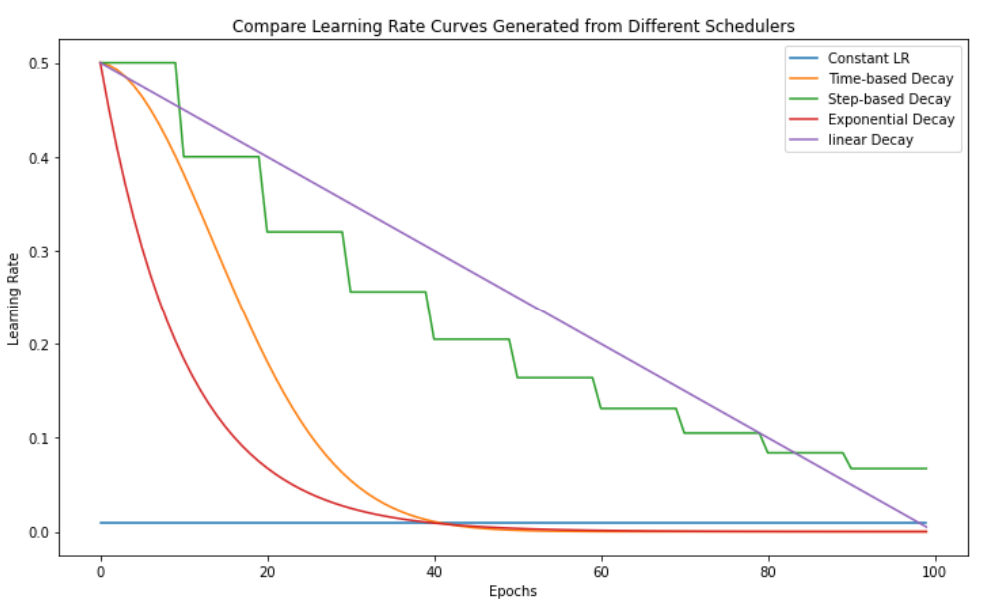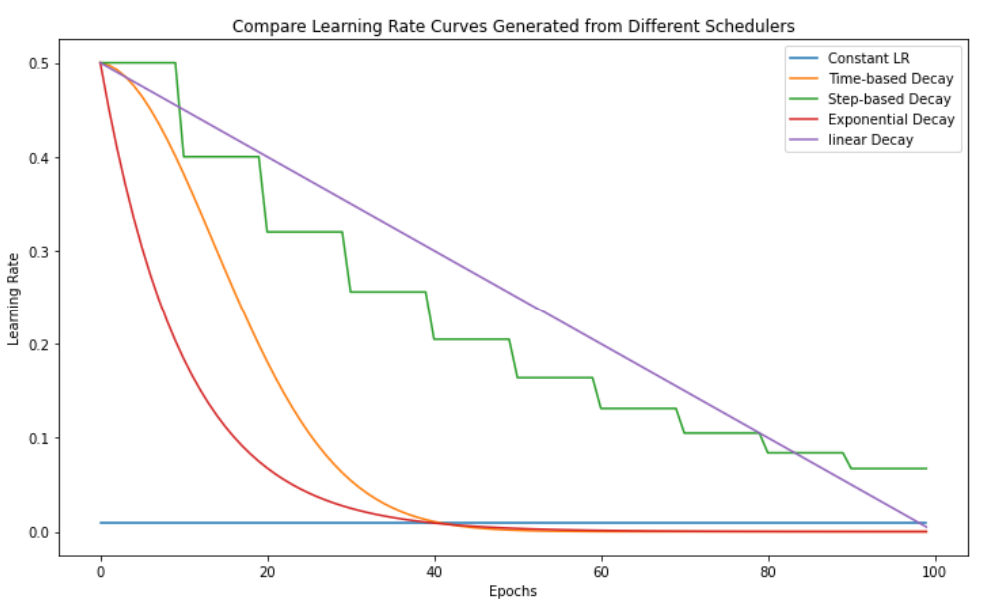

We will demonstrate the effectiveness of a few LR schedulers on a model trained using the stochastic gradient descent (SGD) optimization method, on the CIFAR-10 dataset for an binary image classification task.

Task and model definition
CIFAR-10 is a popular image classification dataset used in computer vision and deep learning. It is comprised of 60,000 32×32 pixel colored images of objects belonging to 10 different classes, that is, airplane, automobile, bird, and so on. In this example, we will be using class 3 (cats) and class 5 (dogs) only.

In the LR scheduler implementations for this reading, we will be using the following settings. As seen in the table below, the LR changes at a different rate for each LR scheduler. Each model will be trained for 50 epochs using the SGD algorithm.

epochs	0	10	25	50
constant	0.01	0.01	0.01	0.01
time-based decay ($LR_0$=0.1, decayRate=LR/#epochs)	0.1	0.099	0.097	0.095
step-based decay ($LR_0$=0.1, drop=0.5, epochsDrop=10)	0.1	0.05	0.025	0.00625
exponential decay ($LR_0$=0.1, k=0.1, momentum=0.8)	0.1	0.037	0.008	0.0006

In [ ]:
#Using the code below, we can load in the CIFAR-10 dataset using the Keras API.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
import numpy as np
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam
from keras.models import model_from_json
from keras.callbacks import LearningRateScheduler
::page{title="input image dimensions"}
img_rows, img_cols = 32, 32  
batch_size = 64
num_classes = 2
epochs = 50
::page{title="the data, shuffled and split between train and test sets"}
(X_train, y_train), (X_test, y_test) = cifar10.load_data()  
::page{title="only look at cats and dogs"}
train_picks = np.ravel(np.logical_or(y_train==3,y_train==5))  
test_picks = np.ravel(np.logical_or(y_test==3,y_test==5))     
y_train = np.array(y_train[train_picks]==5,dtype=int)
y_test = np.array(y_test[test_picks]==5,dtype=int)
X_train = X_train[train_picks]
X_test = X_test[test_picks]


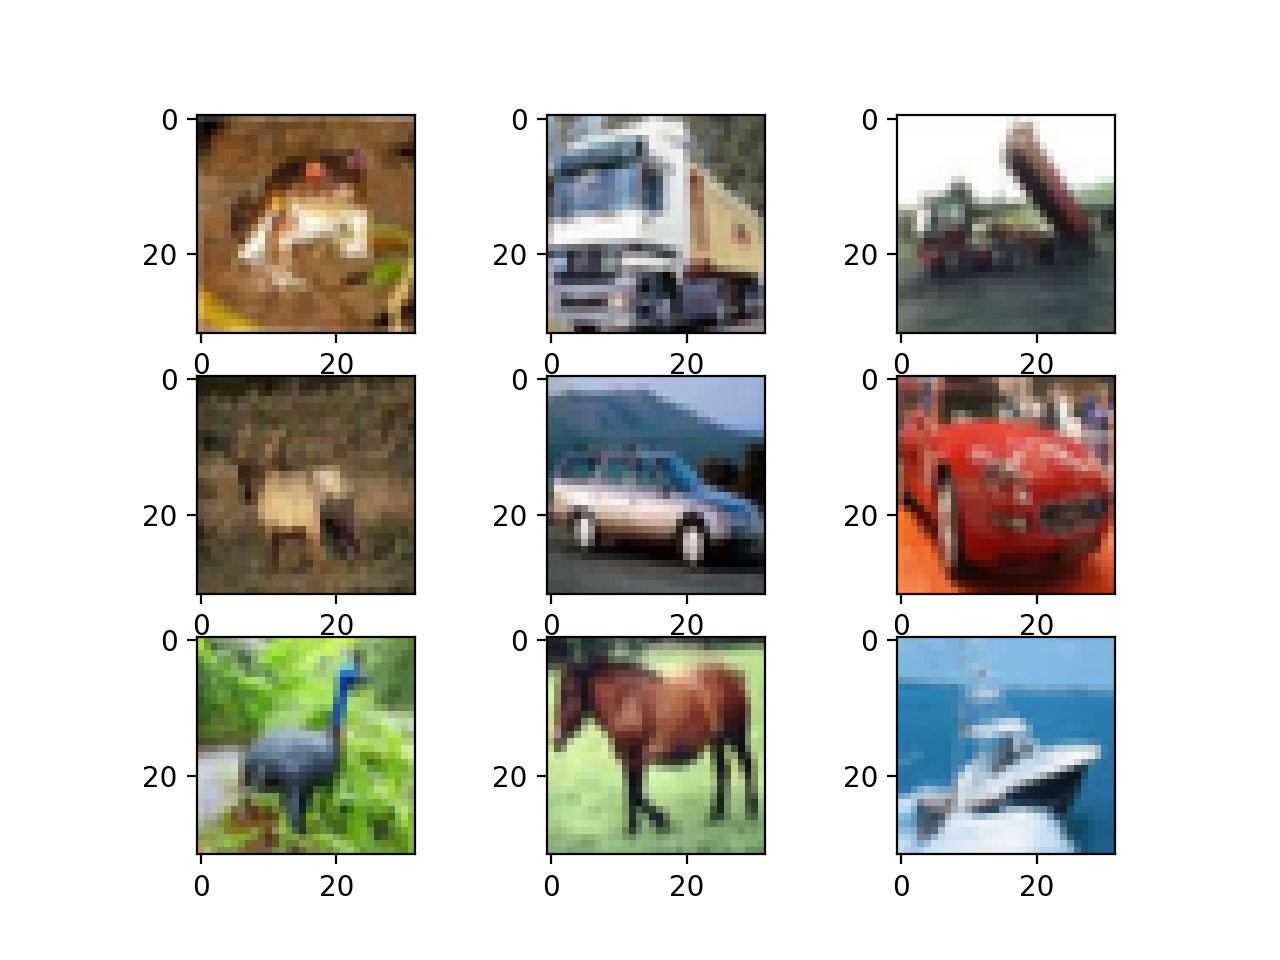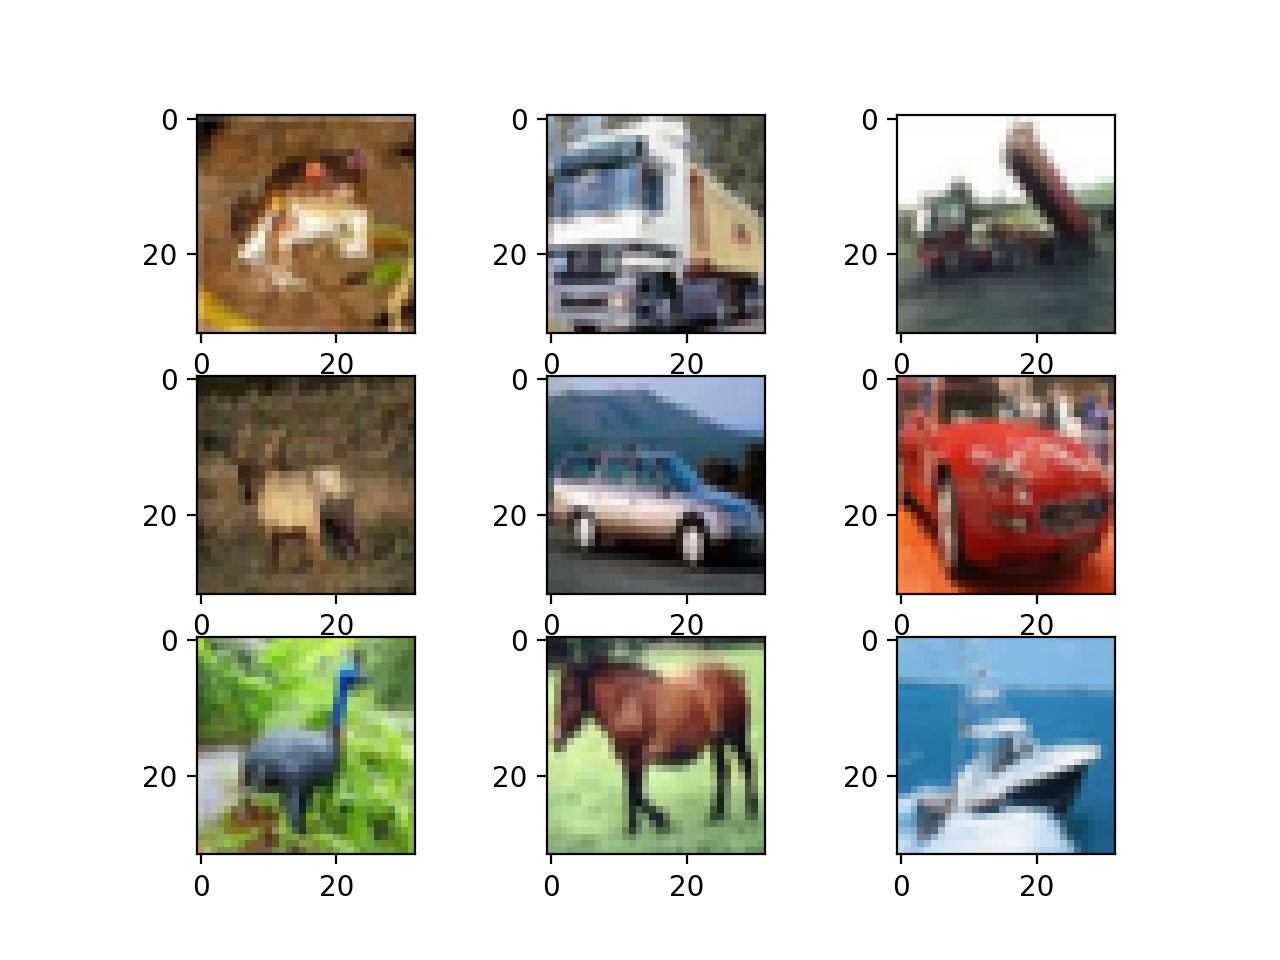

In [ ]:
#the code used to normalize the images.

::page{title="image_data_format() returns the default image data format convention."}
::page{title="based on that, we pick channels_first or channels_last, which is used to define the input shape"}
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [ ]:
#the code used to train the model with a constant LR.

def cnn_model() : 
    model = Sequential()
    model.add(Conv2D(4, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    print(model.summary())
    return(model)

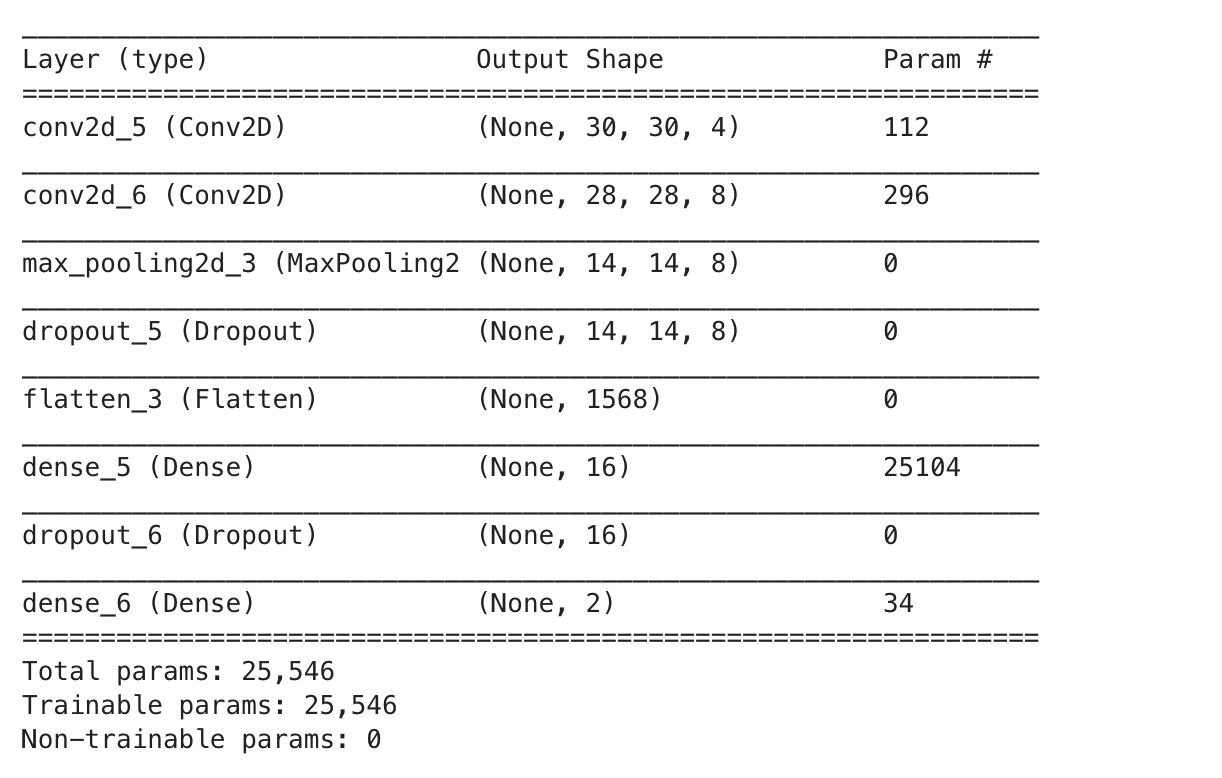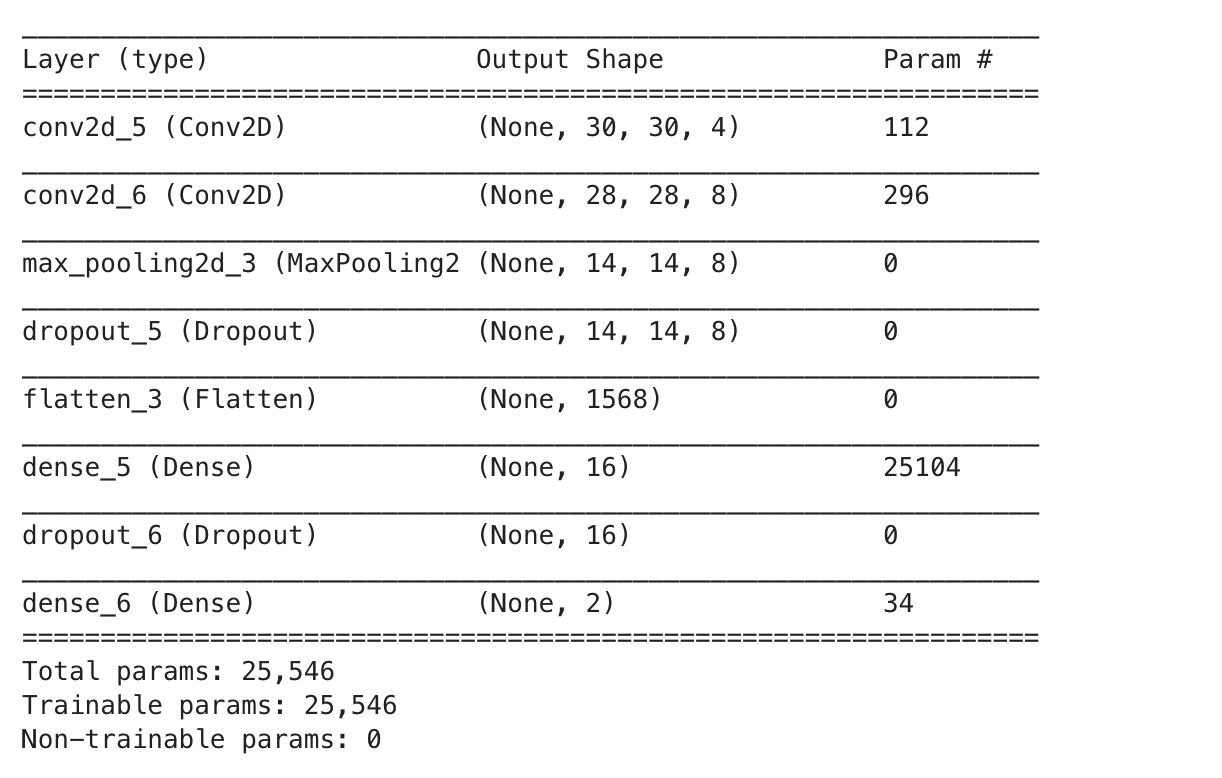

# I. Constant
The default LR schedule for the stochastic gradient descent optimizer in Keras uses a momentum and decay rate of zero and a constant LR. The results for this model will serve as a baseline for us to experiment with different LR techniques. We use the following function to train our model:

In [ ]:
#code used to train the model with a constant LR.
::page{title="define CNN model"}
model1 = cnn_model()
::page{title="define SGD optimizer"}
learning_rate = 0.1
sgd = SGD(lr=learning_rate, momentum=0.0, decay=0.0, nesterov=False) # set to default except lr
::page{title="compile the model"}
model1.compile(loss=keras.losses.categorical_crossentropy, optimizer=sgd, metrics=['accuracy'])
::page{title="fit the model"}
history1 = model1.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=2,
                validation_data=(X_test, y_test))

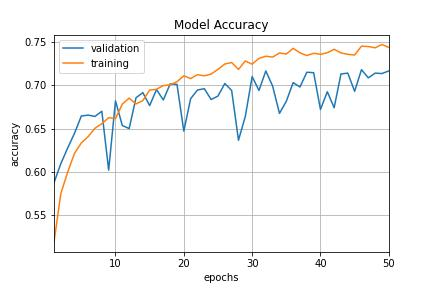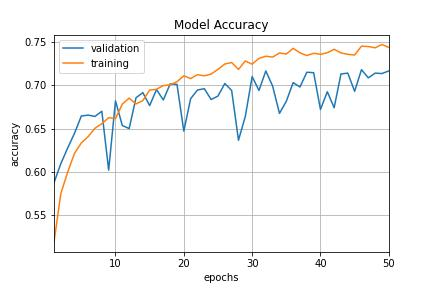

#II. Time-based decay LR Scheduler:
This LR scheduler technique takes in a learning decay rate. We initialize our SGD optimizer with a LR of 0.1 and then set our decay to be the LR divided by the total number of epochs. Keras updates the LR after every batch update. The update formula used by Keras is 

LR=LR0 /(1+k∗t) 

where $LR_0$ is the initial LR, $k$ is the decay rate, and $t$ is the total number of steps per epoch (or weight updates). In CIFAR-10, we have 50,000 training images. We set our batch size to 64. Therefore a total of 50,000/64 weight updates need to be applied per epoch. Our initial LR is 0.1, and decay rate is 0.1/50.

In [ ]:
#the code used to train the model with a time-based decay LR scheduler.

::page{title="define CNN model"}
model2 = cnn_model()
::page{title="define SGD optimizer"}
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.5
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
::page{title="compile the model"}
model2.compile(loss=keras.losses.categorical_crossentropy, optimizer=sgd, metrics=['accuracy'])
::page{title="fit the model"}
history2 = model2.fit(X_train, y_train, 
                     epochs=epochs, 
                     batch_size=batch_size,
                     verbose=2, 
                     validation_data=(X_test, y_test))

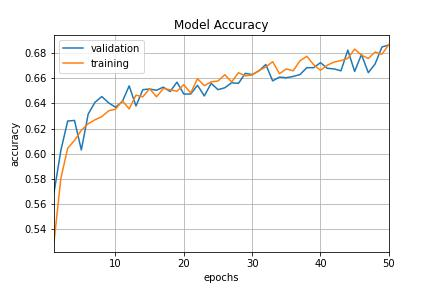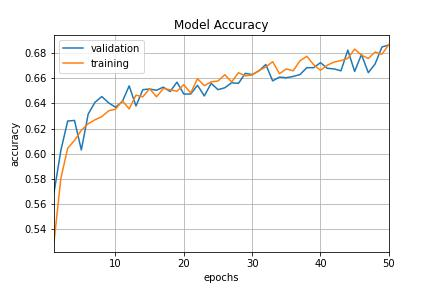

III. Step based-decay LR Scheduler:
This technique decreases the learning rate by a factor every few epochs. For example, we could halve the LR every 10 epochs. This can be defined by the following formula:
            
LR = LRo * dropfloor (epoch/epochsarop)

Here, $drop$ is 50%, $epoch_{drop}$ is the number of epochs after which we update the LR, which in this case is 10.

We use the LR scheduler callback which takes in the step decay function and return the updated LR to the optimizer.

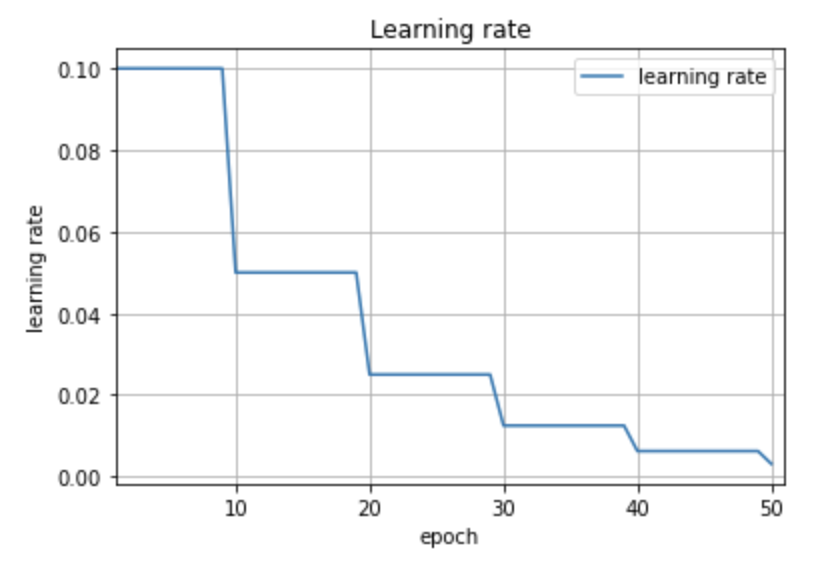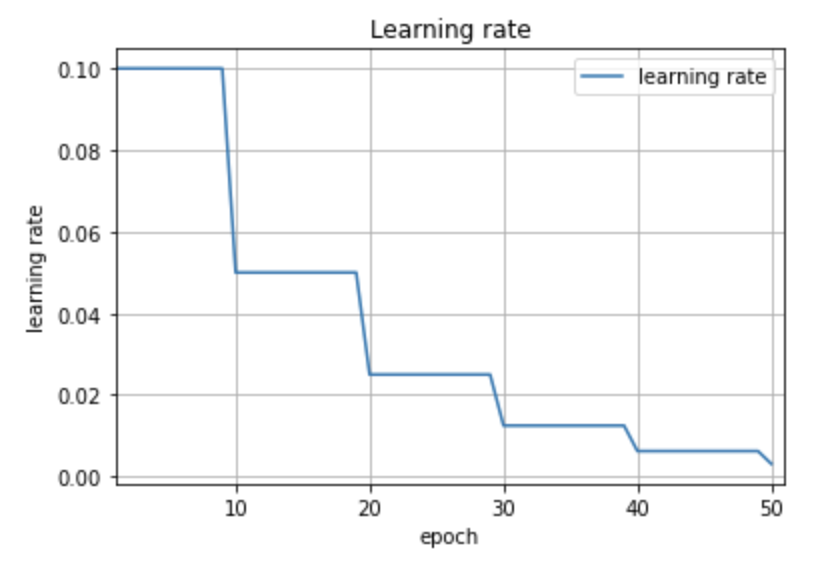

In [ ]:
# the code used to train the model with a step decay LR scheduler.
::page{title="define CNN model"}
model3 = cnn_model()
::page{title="define SGD optimizer"}
momentum = 0.5
sgd = SGD(lr=0.0, momentum=momentum, decay=0.0, nesterov=False) 
::page{title="compile the model"}
model3.compile(loss=keras.losses.categorical_crossentropy,optimizer=sgd, metrics=['accuracy'])
::page{title="define step decay function"}
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lrate
::page{title="learning schedule callback"}
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
callbacks_list = [loss_history, lrate]
::page{title="fit the model"}
history3 = model3.fit(X_train, y_train, 
                     validation_data=(X_test, y_test), 
                     epochs=epochs, 
                     batch_size=batch_size, 
                     callbacks=callbacks_list, 
                     verbose=2)

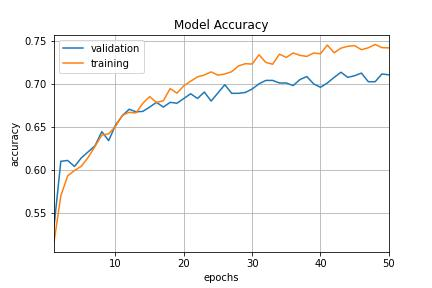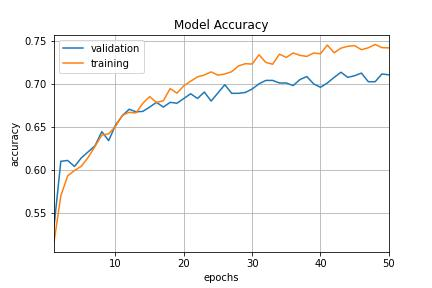

IV. Exponential decay LR Scheduler:
This is another commonly used LR scheduler technique. It is based on the following formula: 
        (−1∗kt)
LR=LR0∗e 
 
 
 . As we did in the case of step decay, here we define an exponential decay function and pass it to LearningRateScheduler callback.

In [ ]:
#the code used to train the model with an exponential decay LR scheduler.

::page{title="define CNN model"}
model4 = cnn_model()
::page{title="define SGD optimizer"}
momentum = 0.8
sgd = SGD(lr=0.0, momentum=momentum, decay=0.0, nesterov=False)
::page{title="compile the model"}
model4.compile(loss=keras.losses.categorical_crossentropy, optimizer=sgd, metrics=['accuracy'])
::page{title="define step decay function"}
class LossHistory_(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses)))
        print('lr:', exp_decay(len(self.losses)))
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
::page{title="learning schedule callback"}
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)
callbacks_list_ = [loss_history_, lrate_]
::page{title="fit the model"}
history4 = model4.fit(X_train, y_train, 
     validation_data=(X_test, y_test), 
     epochs=epochs, 
     batch_size=batch_size, 
     callbacks=callbacks_list_, 
     verbose=2)
Copied!
Exponential decay learning rate scheduler

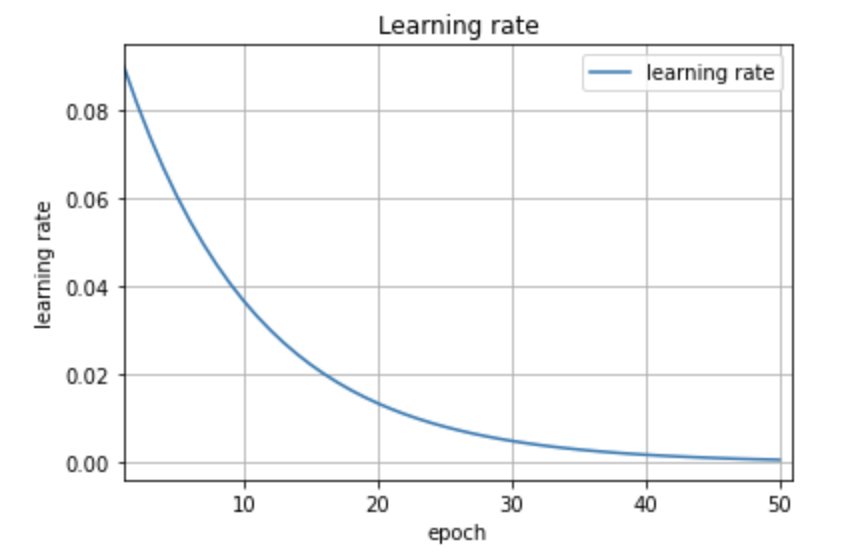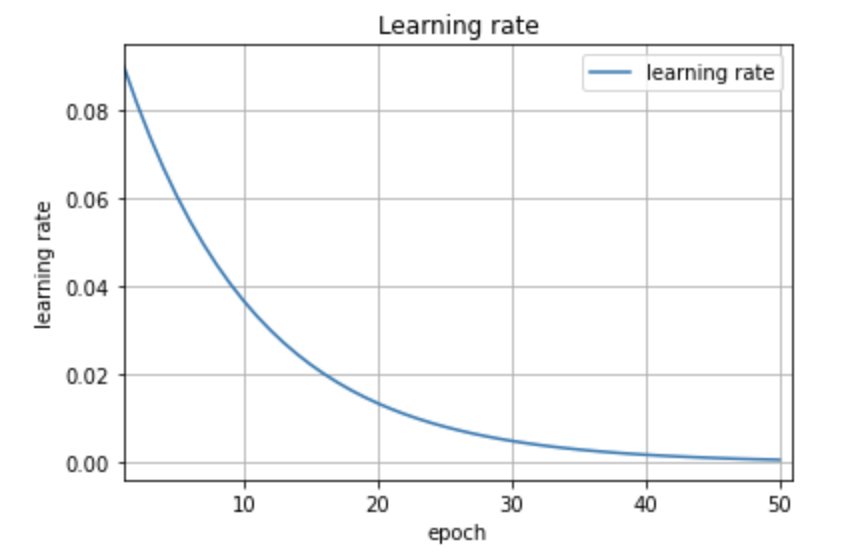

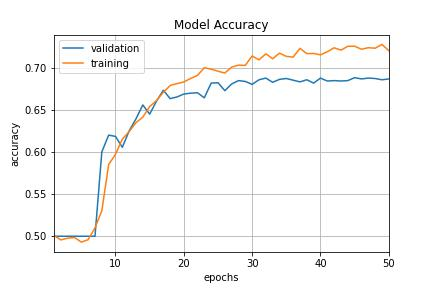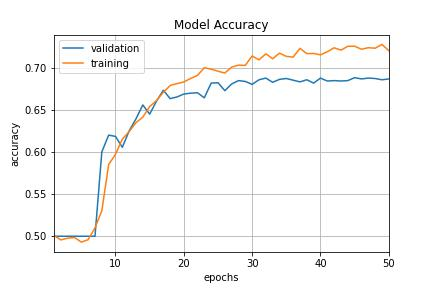

In this reading, we used the LearningRateScheduler in Keras to define custom LR schedules. In most cases, we see that using some form of a LR scheduling technique improves our model’s performance, in comparison to the constant LR schedule which is used in Keras, by default.